# WorkFlow of MSI processing



In [1]:
import h5py
import re
import os
import imageio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyimzml.ImzMLParser import ImzMLParser

from csbdeep.models import CARE
from PIL import Image
from ISR.models import RRDN

from miplib.data.containers.image import Image as resImage
import miplib.analysis.resolution.fourier_ring_correlation as frc
from miplib.data.containers.fourier_correlation_data import FourierCorrelationDataCollection
import miplib.ui.plots.frc as frcplots
from miplib.ui.cli import miplib_entry_point_options as options


In [13]:
a = [[[1,2,3],[2,3,5]],
     [[1,2,3],[2,3,5]],
     [[1,2,3],[2,3,5]],
     [[1,2,3],[2,3,5]]]
a = np.array(a)

b = a.reshape(8,3)
print(a.reshape(8,3))
print(a.shape)
print(b.shape)
print(np.mean(a, axis=0))

[[1 2 3]
 [2 3 5]
 [1 2 3]
 [2 3 5]
 [1 2 3]
 [2 3 5]
 [1 2 3]
 [2 3 5]]
(4, 2, 3)
(8, 3)
[[1. 2. 3.]
 [2. 3. 5.]]


## Class for interior format to store raw data

This object also contains basic operations: save2path, transfer2image, visual

In [92]:
class Data(object):
    """
    A structure to store the data to be preprocessed
    """
    def __init__(self, data, x, y):
        self.mzdata = data
        self.xcoord = np.array(x)
        self.ycoord = np.array(y)
        self.dim_xy = np.array([max(self.xcoord), max(self.ycoord)])
        self.common_mz = self.get_commonMZ()
        self.counts_mat = self.get_countsMatrix()
        self.backgrd = self._get_background()
        
    def visual(self, mz = 256):
        num = len(self.xcoord)
        image = np.zeros((self.dim_xy[1], self.dim_xy[0]))

        for i in range(num):
            
            position = np.where(np.ceil(self.mzdata[i]['mz']) == np.ceil(mz))[0]
            if len(position) > 0:
                image[self.ycoord[i]-1][self.xcoord[i]-1] = sum(self.mzdata[i]['count'][position])
        fig = plt.figure(figsize = (5,5))
        p = plt.imshow(image)
        plt.show()
        #cbar = fig.colorbar(p, orientation='vertical', ticks=[0, np.max(image)], shrink = 0.8)

    def get_commonMZ(self):
        common_mz = np.array([])
        for idx in self.mzdata:
            common_mz = np.concatenate((common_mz, np.around(self.mzdata[idx]["mz"], decimals=1)))
        common_mz = np.unique(common_mz)   # 8002
        return common_mz

    def _get_background(self):
        # Use the lowest mean value along mz axis as the background noise (which ion image shows minimum intensities)
        mean_spectrum = np.mean(self.counts_mat.reshape(self.dim_xy[1]*self.dim_xy[0], len(self.common_mz)), aixs=0)
        low_mz = np.argmin(mean_spectrum)
        bg = np.mean(self.counts_mat[:, :, low_mz])
        return bg

    def _get_snr(self, image):         ########################### from Andy
        mean_value = np.mean(image)
        snr = 20*np.log10(mean_value / self.backgrd)
        return snr

    def _cal_snr(self, noise_img, clean_img): #################### from blog
        # How to define noise_img?
        noise_signal = noise_img - clean_img
        clean_signal = clean_img

        sum1 = np.sum(clean_signal**2)
        sum2 = np.sum(noise_signal**2)
        snr = 20*np.log10(np.sqrt(sum1) / np.sqrt(sum2))
        return snr

    def filter_lowsnr(self, criteria): # or we can combine this inside model processing (save time)
        new_idx = np.array([])
        criteria = 35
        for idx in range(self.counts_mat.shape[2]):
            tmp_image = self.counts_mat[:, :, idx]
            if self._get_snr(tmp_image) > criteria:
                new_idx.append(idx)
        new_counts_mat = np.array(self.counts_mat[:, :, [new_idx]])
        new_cmz = np.array(self.common_mz[new_idx])
        return new_cmz, new_counts_mat
                
    def get_countsMatrix(self):
        mz_len = 151 #len(self.common_mz)
        print(self.dim_xy)
        counts_mat = np.zeros((self.dim_xy[1], self.dim_xy[0], mz_len))
        for idx in range(mz_len):
            for i in range(len(self.xcoord)):
                position = np.where(np.around(self.mzdata[i]["mz"], decimals=1) == self.common_mz[idx])[0]
                if len(position) > 0:
                    counts_mat[self.ycoord[i]-1, self.xcoord[i]-1, idx] = sum(self.mzdata[i]["count"][position])
        return counts_mat
    
    def save2h5(self, outPath):
        f = h5py.File(outPath, 'w')
        
        for idx in self.mzdata:
            f.create_dataset('mz_' + str(idx), data = self.mzdata[idx]["mz"].astype(np.float))
            f.create_dataset('counts_' + str(idx), data = self.mzdata[idx]["count"].astype(np.float))

        f.create_dataset('x_coord', data = np.array(self.xcoord, dtype = np.float))
        f.create_dataset('y_coord', data = np.array(self.ycoord, dtype = np.float))
        f.close()
  
    '''
    def transfer2image(self, mz = 256):
        image = np.zeros((self.dim_xy[1], self.dim_xy[0], 3))
        
        for i in range(len(self.xcoord)):
            position = np.where(np.ceil(self.mzdata[i]['mz']) == np.ceil(mz))[0]
            if len(position) > 0:
                image[self.ycoord[i]-1][self.xcoord[i]-1][0] = sum(self.mzdata[i]["count"][position])
                image[self.ycoord[i]-1][self.xcoord[i]-1][1] = sum(self.mzdata[i]["count"][position])
                image[self.ycoord[i]-1][self.xcoord[i]-1][2] = sum(self.mzdata[i]["count"][position])
        image = np.array(image)

        return image

    def total2images(self):
        dataset = dict()
        length = len(self.common_mz)
        for idx in range(length):
            image = np.zeros((self.dim_xy[1], self.dim_xy[0], 3))
            for i in range(len(self.xcoord)):
                position = np.where(np.around(self.mzdata[i]["mz"], decimals=1) == self.common_mz[idx])[0]
                if len(position) > 0:
                    image[self.ycoord[i]-1][self.xcoord[i]-1][0] = sum(self.mzdata[i]["count"][position])
                    image[self.ycoord[i]-1][self.xcoord[i]-1][1] = sum(self.mzdata[i]["count"][position])
                    image[self.ycoord[i]-1][self.xcoord[i]-1][2] = sum(self.mzdata[i]["count"][position])
            intensity_mean = np.mean(image)
            image = np.array(image)
            dataset[idx] = image

        return dataset
    '''

In [102]:
#Predata = imzML_to_predata(inMLPath)
#count_mat = Predata.get_countsMatrix()
mz_len = len(Predata.common_mz)
counts_mat = np.zeros((Predata.dim_xy[1], Predata.dim_xy[0], mz_len))
for idx in range(mz_len):
    for i in range(len(Predata.xcoord)):
        position = np.where(np.around(Predata.mzdata[i]["mz"], decimals=1) == Predata.common_mz[idx])[0]
        if len(position) > 0:
            counts_mat[Predata.ycoord[i]-1, Predata.xcoord[i]-1, idx] = sum(Predata.mzdata[i]["count"][position])


In [145]:
print(Predata.common_mz[150])

215.0


(94, 94, 8002)
Loading network weights from 'weights_best.h5'.
Done.
Loading GAN weights...
Done.
Processing single image by ESRGAN...
Processing single image by UNET5...
The resolution of original image is 474.19738174884054.
The resolution of gan_enhanced image is 731.3599408365124.
The resolution of final image is 520.2813040865185.


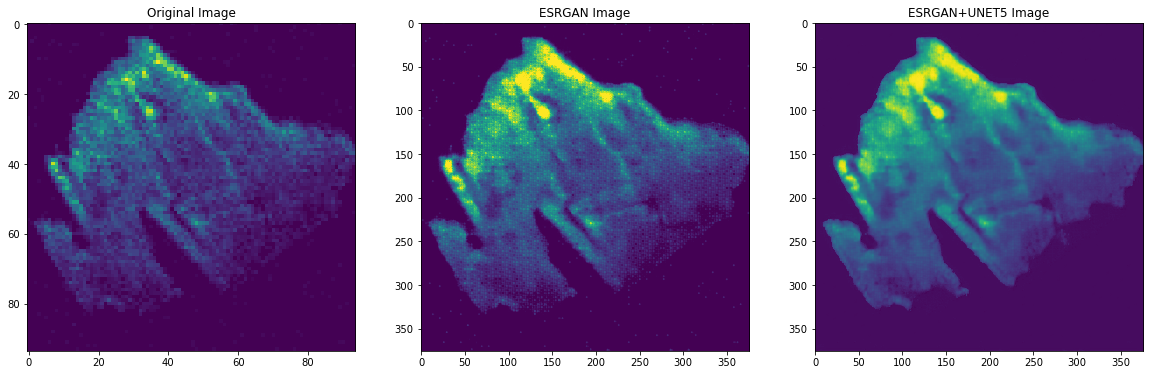

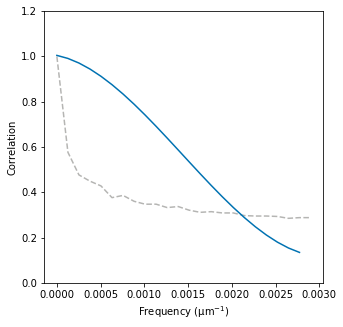

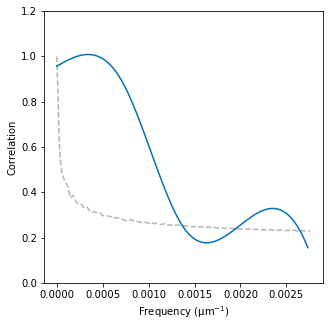

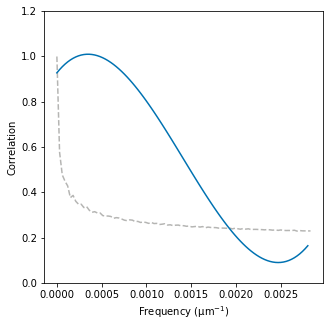

In [131]:
print(counts_mat.shape)
image = np.zeros((counts_mat.shape[0], counts_mat.shape[1], 3))
image[:,:,0] = counts_mat[:,:,150]
image[:,:,1] = counts_mat[:,:,150]
image[:,:,2] = counts_mat[:,:,150]
image = np.array(image)
Model = Process()
gan_image = Model.gan_enhance(image)
unet_image = Model.unet5_denoise(gan_image[:,:,0])
Model.plot_all(image, gan_image, unet_image)

resFRC = FRC()
print("The resolution of original image is {}.".format(resFRC.get_resolution(image[:, :, 0])))
print("The resolution of gan_enhanced image is {}.".format(resFRC.get_resolution(gan_image[:, :, 0])))
print("The resolution of final image is {}.".format(resFRC.get_resolution(unet_image[:, :])))
#resFRC.plot_curve_without_fitting(unet_image)


## Class for model processing

This object contains two trainend DL models for MS imaging enhancement.

In [134]:
class Process(object):
    """
    The processing of the input image data through our trained models (GAN + UNET5)
    """
    def __init__(self):
        self.gan_weights = "D:/BMR-DS/Project_2/Code/weights/rrdn-C4-D3-G32-G032-T10-x4_best-val_generator_loss_epoch051.hdf5"
        self.unet5_weights = "D:/BMR-DS/Project_2/Code/weights"

        self.unet5Model = self.unet5_load_weights()
        self.gan_load_weights()

    def unet5_load_weights(self):
        #print("Loading UNET5 weights...")
        unet5Model = CARE(config = None, name = '400s_40ep_0.5n', basedir = self.unet5_weights)
        print("Done.")
        return unet5Model

    def gan_load_weights(self):
        self.ganModel = RRDN(arch_params={'C': 4, 'D':3, 'G':32, 'G0':32, 'T': 10, 'x':4})
        print("Loading GAN weights...")
        gan_path = "D:/BMR-DS/Project_2/Code/weights/rrdn-C4-D3-G32-G032-T10-x4_best-val_generator_loss_epoch051.hdf5"
        self.ganModel.model.load_weights(gan_path)
        print("Done.")
        
    def gan_enhance(self, image, saveFlag = False, outPath = '', format = 'png'):
        # image is 3-D version
        print("Processing single image by ESRGAN...")
        gan_image = self.ganModel.predict(image)

        if saveFlag and format == '.png':
            self.save2png(gan_image, outPath)

        return gan_image

    def unet5_denoise(self, image, saveFlag = False, outPath = ''):
        # image is 2-D version
        print("Processing single image by UNET5...")
        unet5_image = self.unet5Model.predict(image, axes = 'YX')

        if saveFlag and format == '.png':
            self.save2png(unet5_image, outPath, format)

        return unet5_image

    def gan_unet5(self, image, saveFlag = False, outPath = '', format = '.png'):
        # image is 3-D version
        print("Processing single image by ESRGAN and UNET5...")
        gan_image = self.ganModel.predict(image)
        unet5_image = self.unet5Model.predict(gan_image[:, :, 0], axes = 'YX')
        
        if saveFlag and format == '.png':
            self.save2png(unet5_image, outPath)

        return unet5_image

    def save2png(self, image, outPath): ## image name??
        saved_image = Image.fromarray(image)
        saved_image.save(outPath)

    def plot_original_image(self, image):
        plt.figure(figsize=(10, 8))
        plt.imshow(image[:,:,0])
        plt.title("Original Image",fontsize = 30)

    def plot_gan_image(self, image):
        plt.figure(figsize=(10, 8))
        plt.imshow(image[:, :, 0])
        plt.title("ESRGAN Image",fontsize = 30)

    def plot_unet5_image(self, image):
        plt.figure(figsize=(10,8))
        plt.imshow(image[:,:])
        plt.title("UNET5 Image",fontsize = 30)
    
    def plot_all(self, image, gan_image, unet5_image):
        plt.figure(figsize=(10, 8))

        plt.subplot(131)
        plt.imshow(image[:, :, 0])
        plt.title("Original Image")

        plt.subplot(132)
        plt.imshow(gan_image[:, :, 0])
        plt.title("ESRGAN Image")

        plt.subplot(133)
        plt.imshow(unet5_image[:,:])
        plt.title("ESRGAN+UNET5 Image")

## Class FRC to calculate resolution using FRC

In [122]:
class FRC(object):
    def __init__(self, spacing = [100.0, 100.0]):
        self.spacing = spacing # physical size of each pixel (um)
        #self.image = resImage(image - image.min(), self.spacing)
        self.args = self.setup()

    def setup(self):
        args_list = ("None --bin-delta=1  --frc-curve-fit-type=smooth-spline "  
             " --resolution-threshold-criterion=half-bit").split()

        args = options.get_frc_script_options(args_list)

        return args
        
    def image2Image(self, image):
        image = resImage(image, self.spacing)
        return image

    def get_resolution(self, image):
        # image is in resImage format
        image = self.image2Image(image)
        frc_results = FourierCorrelationDataCollection()

        frc_results[0] = frc.calculate_single_image_frc(image, self.args)
        frcplots.plot_resolution_curves(frc_results,size = (5,5))
        resolution = frc_results[0].resolution["resolution"]

        return resolution

    def plot_curve_without_fitting(self, image):
        # Cannot get the resolution
        image = self.image2Image(image)
        frc_results = FourierCorrelationDataCollection()

        frc_results = frc.calculate_single_image_frc_without_fit(image, self.args)
        X = frc_results[0].correlation["frequency"]
        Y = frc_results[0].correlation["correlation"]
        print("Frequency: \n {}".format(X))
        print("Correlation: \n {}".format(Y))

        # Plot the result without fitting
        plt.figure(figsize=(5,5))
        plt.plot(X, Y)

## Some functions to read or convert different format data

In [5]:
def imzML_to_h5(inPath, outPath):
    p = ImzMLParser(inPath)
    f = h5py.File(outPath, 'w')
    
    xcoord = []
    ycoord = []
    for idx, (x,y,z) in enumerate(p.coordinates):
        mzs, intensities = p.getspectrum(idx)
        f.create_dataset('mz_' + str(idx), data = mzs.astype(np.float))
        
        f.create_dataset('counts_' + str(idx), data = intensities.astype(np.float))
        xcoord.append(x)
        ycoord.append(y)
    f.create_dataset('x_coord', data = np.array(xcoord, dtype = np.float))
    f.create_dataset('y_coord', data = np.array(ycoord, dtype = np.float))
    f.close()

def imzML_to_predata(inPath):
    p = ImzMLParser(inPath)
    data = dict()

    xcoord = []
    ycoord = []
    for idx, (x,y,z) in enumerate(p.coordinates):
        mzs, intensities = p.getspectrum(idx)
        data[idx] = dict()
        data[idx]["count"] = np.array(intensities.astype(np.float))
        data[idx]["mz"] = np.array(mzs.astype(np.float))
        xcoord.append(x)
        ycoord.append(y)
    PreData = Data(data, xcoord, ycoord)
    return PreData

def h5_to_predata(inPath):
    f = h5py.File(inPath, 'r')
    x = np.array(f['x_coord']).astype(np.int64)
    y = np.array(f['y_coord']).astype(np.int64) ### !!!!!

    data = dict()
    for key in f.keys():
        if re.match("counts_", key):
            idx = int(key[7:])
            data[idx] = dict()
            
            data[idx]['count'] = np.array(f[key])
            data[idx]['mz'] = np.array(f['mz_'+str(idx)])
    PreData = Data(data, x, y)
    f.close()
    return PreData
'''
def image_to_h5(dataset, common_mz, outPath):
    f = h5py.File(outPath, 'w')
    #xcoord = []
    #ycoord = []
    counts_mat = []
    for idx in dataset:
        image = dataset[idx]
        tmp = []
        for j in range(len(image)):
            for i in range(len(image[j])):
                tmp.append(image[j][i][0])
                #xcoord.append(i+1)
                #ycoord.append(j+1)
        counts_mat.append(tmp)
    #f.create_dataset('x_coord', data = np.array(xcoord, dtype = np.float))
    #f.create_dataset('y_coord', data = np.array(ycoord, dtype = np.float))
    f.create_dataset('dim_xy', data = np.array([len(dataset[0][0]), len(dataset[0])], dtype = np.int))
    f.create_dataset('counts_mat', data = np.array(counts_mat, dtype = np.float))
    f.create_dataset('cmz', data = np.array(common_mz, dtype = np.float))
    f.close()
'''

def countsmatrix_to_h5(counts_mat, common_mz, dim_xy, outPath):
    f = h5py.File(outPath, 'w')
    f.create_dataset("dim_xy", data = np.array(dim_xy, dtype = np.int))
    f.create_dataset("cmz", data = np.array(common_mz, dtype = np.float))
    f.create_dataset("counts_mat", data = np.array(counts_mat, dtype = np.float))
    f.close()

In [6]:
if __name__ == "__main__":
    # Local Paths
    inMLPath = "D:/BMR-DS/Project_2/DataSet/DESI Example/DESI Example/A30.imzml"
    inH5Path = "D:/BMR-DS/Project_2/DataSet/DESI Example/DESI Example/A30.h5"
    outH5Path = "D:/BMR-DS/Project_2/DataSet/DESI Example/DESI Example/test.h5"

    #Predata = h5_to_predata(inH5Path)
    Predata = imzML_to_predata(inMLPath)
    #Predata.visual()


d:\Anaconda\envs\miplib\lib\site-packages\pyimzml\ontology\ontology.py:94: UserWarning: Accession MS:1000563 found with incorrect name "Thermo RAW file". Updating name to "Thermo RAW format".
  % (accession, raw_name, name)
d:\Anaconda\envs\miplib\lib\site-packages\pyimzml\ontology\ontology.py:94: UserWarning: Accession MS:1000590 found with incorrect name "contact organization". Updating name to "contact affiliation".
  % (accession, raw_name, name)
d:\Anaconda\envs\miplib\lib\site-packages\pyimzml\ontology\ontology.py:94: UserWarning: Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".
  % (accession, raw_name, name)
d:\Anaconda\envs\miplib\lib\site-packages\pyimzml\ontology\ontology.py:94: UserWarning: Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".
  % (accession, raw_name, name)
d:\Anaconda\envs\miplib\lib\site-packages\pyimzml\ontology\ontology.py:94: Us

## Single image processing -- from raw to resolution

Only extract one image from raw data

The MS image is generated from choosing one peak (mz=256) from raw data cube.

In [10]:
def process_single_image(inPath, mz = 255):
    if re.match("(.*)\.h5$", inPath):
        Predata = h5_to_predata(inPath)
    elif re.match("(.*)\.imzml$", inPath):
        Predata = imzML_to_predata(inPath)
    
    #Predata.visual()

    # Model processing
    Model = Process()
    image = Predata.transfer2image(mz)
    gan_image = Model.gan_enhance(image)
    unet_image = Model.unet5_denoise(gan_image[:,:,0])

    # Plot all images
    Model.plot_all(image, gan_image, unet_image)
    
    # Calculate resolution
    resFRC = FRC()
    ori = resFRC.get_resolution(image[:, :, 0])
    enh = resFRC.get_resolution(gan_image[:, :, 0])
    den = resFRC.get_resolution(unet_image)

    return (ori, enh, den)

## Multiple images processing -- from images to resolution

The input is a folder of .png format images.

In [ ]:
def process_multiple_images(fdrPath, save = False, outPath = None):
    frc_results = dict()
    resFRC = FRC()

    flist = os.listdir(fdrPath)
    for f in flist:
        fpath = os.path.join(fdrPath, f)
        image = imageio.imread(fpath)
        try:
            frc_results[f] = resFRC.get_resolution(image)
        except:
            print("{} cannot be sovled.".format(f))        

    if save:
        result = pd.DataFrame()
        result["file\ name"] = frc_results.keys()
        result["resolution"] = frc_results.values()
        result.to_excel(outPath)
        
    return frc_results

## Raw data processing -- from raw to resolution

The input is the imzML format raw data.

First, transfer the imzML data to numpy_image; Then, process and solve the numpy_image.

How to get "count_matrix.h5", normalise the mz vector. (different types of tissue need the same method)

In [ ]:
'''
def process_raw_data(inPath):
    if re.match("(.*)\.h5$", inPath):
        Predata = h5_to_predata(inPath)
    elif re.match("(.*)\.imzml$", inPath):
        Predata = imzML_to_predata(inPath)

    Model = Process()
    dataset = Predata
    enh_dataset = dict()
    resolution_dataset = dict()
    for i in dataset:
        image = np.array(dataset[i])
        enh_image = Model.gan_unet5(image)
        enh_dataset[i] = enh_image
        
        resFRC = FRC()
        resolution_dataset[i] = resFRC.get_resolution(enh_image[:, :])

    return enh_dataset, resolution_dataset
'''
def process_raw_data(inPath):
    if re.match("(.*)\.h5$", inPath):
        Predata = h5_to_predata(inPath)
    elif re.match("(.*)\.imzml$", inPath):
        Predata = imzML_to_predata(inPath)

    Model = Process()
       

In [ ]:
def _process_single(image):
    resFRC = FRC()
    resolution = resFRC.get_resolution(image)
    
    return resolution